In [1]:
import sys
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random
import time

from scipy.stats import chi2
from scipy import special
from scipy.special import entr, logsumexp, betaln, gammaln as gamln, zeta
from scipy.stats import poisson
from scipy.stats import norm
from scipy.integrate import simps

from os import listdir
import re

matplotlib.rcParams.update({'font.size': 14})

# 1D Plotting Method

In [2]:
def plot1D(data, color='k', label=None, linestyle='-', style='step', marker='.'):
    # extract data
    x,y,yerr = data[0], data[1], data[2]
    
    # plot binned data
    if style == 'step':
        plt.step(np.append(0,x), np.append(y[0],y), linestyle=linestyle, color=color, label=label)
        plt.errorbar(x, y, yerr=yerr, fmt='none', color=color)
    elif style == 'scatter':
        plt.scatter(x, y, color=color, label=label, marker=marker)
        plt.errorbar(x, y, yerr=yerr, fmt='none', color=color)
    else:
        print('Error: No such style method')

# 2D Plotting Method

In [3]:
def plot2D(data, bins1, bins2, ax = None, cmap='jet', vmax=None,):
    if vmax == None:
        vmax = np.max(data.T[2])
    if ax == None:
        ax = plt.subplot(1,1,1)
        
    # plot signal data
    hs = ax.hist2d(
        data.T[0], data.T[1], weights=data.T[2],
        bins=[bins1,bins2], range=[[bins1[0], bins1[-1]],[bins2[0], bins2[-1]]],
        norm=matplotlib.colors.LogNorm(vmax = vmax),cmap=cmap,
    )
    return hs

In [4]:
def plot2Dratio(hs, hb, bins1, bins2, ax = None, cmap='jet', vmax=None,):
    if vmax == None:
        vmax = np.max(data.T[1])
    if ax == None:
        ax = plt.subplot(1,1,1)
    
    selected_data_r = []
    vmin, vmax = 10e10,0
    for ix in range(len(bins1)-1):
        x = (bins1[ix+1]+bins1[ix])/2.
        for iy in range(len(bins2)-1):
            y = (bins2[iy+1]+bins2[iy])/2.
            if hb[0][ix][iy]==0: r = 0
            else: r=hs[0][ix][iy]/hb[0][ix][iy]
            selected_data_r.append([x,y,r])
            if r>0 and r<vmin: vmin=r
            if r>vmax: vmax=r
    selected_data_r = np.array(selected_data_r)
        
    ax = plt.subplot(1,3,3)
    hr = ax.hist2d(
        selected_data_r.T[0], selected_data_r.T[1], weights=selected_data_r.T[2],
        bins=[bins1,bins2], range=[[bins1[0], bins1[-1]],[bins2[0], bins2[-1]]],
        norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax),cmap='jet',
    )
    return hr

# Flux Plots

In [5]:
expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')

expEnergy = expectedData1[:,0]
# expFlu has units of GeV^-1 cm^-2 s^-1
# Multiply by energy bin width (200 GeV/bin) to change to cm^-2 s^-1 /bin

expFluNmu = expectedData1[:,1] * 200
expFluPmu = expectedData2[:,1] * 200

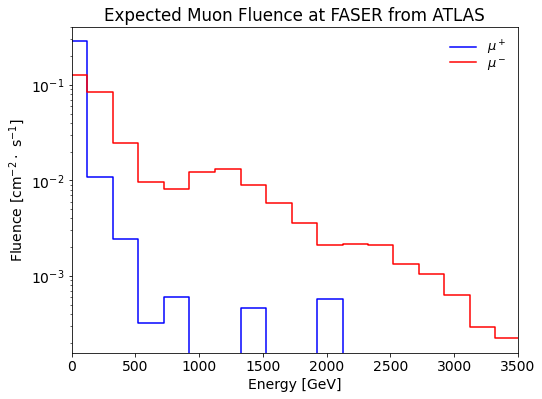

In [6]:
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(1,1,1)

dataset1 = np.array([expEnergy, expFluPmu, np.zeros(np.shape(expFluPmu))])
dataset2 = np.array([expEnergy, expFluNmu, np.zeros(np.shape(expFluNmu))])

plt.sca(ax)
plot1D(dataset1, style='step', color='b', label='$\mu^+$')
plot1D(dataset2, style='step', color='r', label='$\mu^-$')

plt.xlim([0,3500])
plt.yscale('log')
plt.legend(frameon=False, labelspacing=0, fontsize=13)
plt.xlabel('Energy [GeV]')
plt.ylabel('Fluence [cm$^{-2} \cdot$ s$^{-1}$]')
plt.title('Expected Muon Fluence at FASER from ATLAS')
fig.savefig('GeneratedPlots/expMuonFluence.pdf')

In [7]:
LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC

A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2
A_c = 35 * 30 # center cimulation area in cm^2
A_tot = A_lr + A_tb + A_c
veto = 10 ** -6
A_tot_veto = A_lr + A_tb + A_c * veto

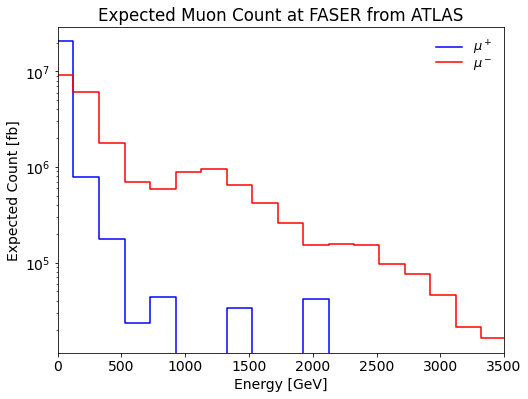

In [8]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)

scale = A_tot / LHCflu
dataset1 = np.array([expEnergy, expFluPmu * scale, np.zeros(np.shape(expFluPmu))])
dataset2 = np.array([expEnergy, expFluNmu * scale, np.zeros(np.shape(expFluNmu))]) 

plt.sca(ax)
plot1D(dataset1, style='step', color='b', label='$\mu^+$')
plot1D(dataset2, style='step', color='r', label='$\mu^-$')

plt.xlim([0,3500])
plt.yscale('log')
plt.legend(frameon=False, labelspacing=0, fontsize=13)

plt.xlabel('Energy [GeV]')
plt.ylabel('Expected Count [fb]')
plt.title('Expected Muon Count at FASER from ATLAS')

fig.savefig('GeneratedPlots/expMuonCount.pdf')

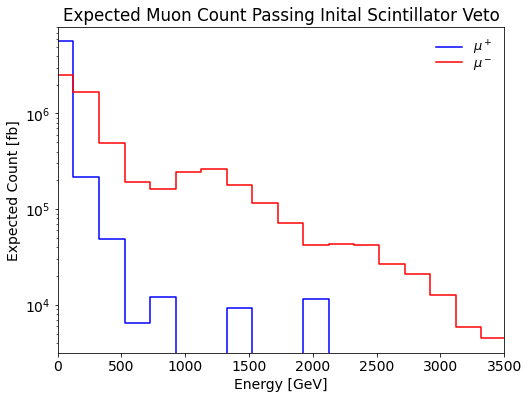

In [9]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)

scale = A_tot_veto / LHCflu
dataset1 = np.array([expEnergy, expFluPmu * scale, np.zeros(np.shape(expFluPmu))])
dataset2 = np.array([expEnergy, expFluNmu * scale, np.zeros(np.shape(expFluNmu))]) 

plt.sca(ax)
plot1D(dataset1, style='step', color='b', label='$\mu^+$')
plot1D(dataset2, style='step', color='r', label='$\mu^-$')

plt.xlim([0,3500])
plt.yscale('log')
plt.legend(frameon=False, labelspacing=0, fontsize=13)

plt.xlabel('Energy [GeV]')
plt.ylabel('Expected Count [fb]')
plt.title('Expected Muon Count Passing Inital Scintillator Veto')

fig.savefig('GeneratedPlots/expMuonCountPass.pdf')

## Event Displays

In [10]:
def plot_tracker_image(event):
    image = np.array(event['hits1'])
    E = np.round(event['calorimeter'],1)
    if E >= 100:
        E = int(np.round(E,0))
    N = int(event['ntracks_1'])
    C = np.round(event['centrality_1'],2)
    S = np.round(event['spread_1'],2)
    
    if len(image)==0: image = np.array([[0,0,0]])
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    hist = plt.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins,
                             norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
    plt.text(12,-12,"$E=$"+str(E)+" GeV", fontsize=10, ha='right')
#     plt.text(-12,-12,"$E=$"+str(E)+"\n$N=$"+str(N)+"\n$C=$"+str(C)+"\n$S=$"+str(S), fontsize=10)
    return hist

In [11]:
numu_events = np.load("PlotsDataArrays/numu_events.npy", allow_pickle=True)
muon_events = np.load("PlotsDataArrays/muon_events.npy", allow_pickle=True)

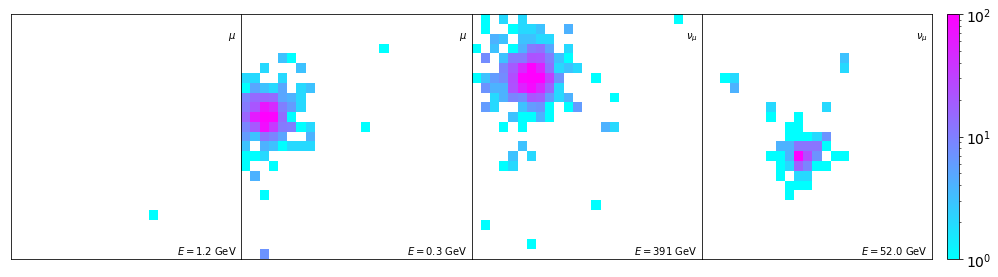

In [12]:
# Set up some nice axes

fig = plt.figure(figsize=(16,4))
# Setup some nice axes
x0 = 0.075
y0, y1 = 0.05, 0.85 
w = 0.2 # 0.88 / 4

ax0 = fig.add_axes([x0       , y0    , w, y1])
ax1 = fig.add_axes([x0 + w   , y0    , w, y1])
ax2 = fig.add_axes([x0 + 2*w , y0    , w, y1])
ax3 = fig.add_axes([x0 + 3*w , y0    , w*1.25, y1])
# ax4 = fig.add_axes([x0 + 4*w , y0    , w, y1])

for ax, event in zip([ax0,ax1,ax2,ax3],np.append(muon_events, numu_events)):
    
    plt.sca(ax)
    hist = plot_tracker_image(event)
    plt.xticks([])
    plt.yticks([])
ax0.text(12,10,"$\mu$", fontsize=10, ha='right')
ax1.text(12,10,"$\mu$", fontsize=10, ha='right')
ax2.text(12,10,"$\\nu_\mu$", fontsize=10, ha='right')
ax3.text(12,10,"$\\nu_\mu$", fontsize=10, ha='right')
fig.colorbar(hist[3], ax=ax3)

fig.savefig('GeneratedPlots/Fig_event_displays.pdf')

# Simulation Counts + Statistics

### Muons

In [13]:
def countSimTotals(files):

    simTot = {}
    for side in ['left', 'right', 'top', 'bot']:
        sideDict = {}
        sideFiles = [file for file in files if re.search(f'.*{side}.*', file)]
        for file in sideFiles:
            energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
            if not(energy in sideDict.keys()):
                sideDict[energy] = 21527
            else:
                sideDict[energy] += 21527
        simTot[side] = sideDict
    # Determine simTot for center
    centerDict = {}
    centerFile = [file for file in files if re.search(f'.*center.*', file)]
    for file in centerFile:
        energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
        if not(energy in centerDict.keys()):
            centerDict[energy] = 20000
        else:
            centerDict[energy] += 20000
    simTot['center'] = centerDict

    return simTot



In [14]:
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muons',file)]
    

data = np.array([])
        
# Load fluence files for muons and anti-muons and combine them
expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')

expEnergy = expectedData1[:,0]
expFlu    = expectedData1[:,1] + expectedData2[:,1]

# expFlu has units of GeV^-1 cm^-2 s^-1
# Multiply by energy bin width (200 GeV/bin) to change to cm^-2 s^-1 /bin
expFlu = expFlu * 200

LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER) per bin

A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2
A_c = 35 * 30 # center cimulation area in cm^2

expTot_lr = expFlu * A_lr
expTot_tb = expFlu * A_tb
expTot_c = expFlu * A_c * veto

expTot = 2 * (expTot_lr + expTot_tb) + expTot_c

# Number simulated in each region for each input file
simTotDict = countSimTotals(files)

In [15]:
energies = np.sort(np.fromiter(simTotDict['left'].keys(), dtype=float))

simTot = []
for energy in energies:
    totals = [simTotDict[side][energy] for side in ['left', 'right', 'top', 'bot', 'center']]
    simTot.append(np.sum(totals))

simTot = np.array(simTot)

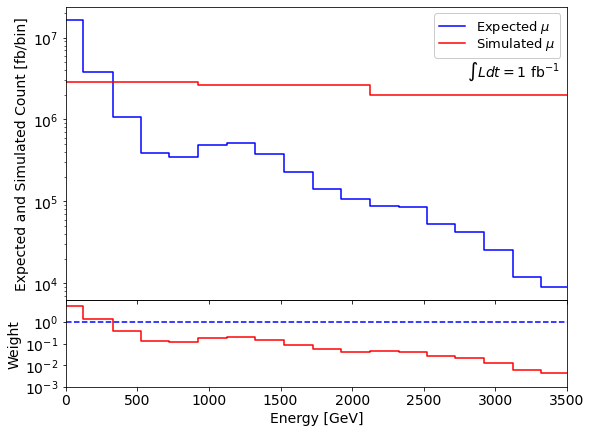

In [16]:
lum = 1
weights = (expTot*lum)/simTot

# Configure datasets for plot1D()
weights_dataset=np.array([expEnergy, weights, np.zeros(np.shape(weights))])
expTot_dataset=np.array([expEnergy, expTot*lum, np.zeros(np.shape(expTot))])
simTot_dataset=np.array([expEnergy, simTot, np.zeros(np.shape(simTot))])

fig = plt.figure(figsize=(8,6))
# Setup some nice axes
x0, x1 = 0.11, 0.98
y0, y1 = 0.1, 0.88 # 0.20 = 0.05 + 0.9/6
h = 0.2

ax0 = fig.add_axes([x0 , y0    , (x1-x0), h])
ax1 = fig.add_axes([x0 , y0 + h, (x1-x0), y1-h])

# Plot the weights
plt.sca(ax0)
plot1D(weights_dataset, color='r')
plot1D(np.array([[0,3500],[1,1], [0, 0]]), linestyle='--', color='b')

ax0.set_xlim([0,3500])
ax0.set_ylim([10**-3,10])
ax0.set_yscale('log')
ax0.set_yticks([10**-3,10**-2,10**-1,1])

ax0.set_xlabel('Energy [GeV]')
ax0.set_ylabel('Weight')

# Plot the counts
plt.sca(ax1)
plot1D(expTot_dataset, color='b', label='Expected $\mu$')
plot1D(simTot_dataset, color='r', label='Simulated $\mu$')

ax1.set_xlim([0,3500])
ax1.set_yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13)
plt.text(2800,3.4*10**6,"$\int L dt = 1 ~\mathrm{fb}^{-1}$")
ax1.set_xticklabels([])
# ax1.set_xlabel('Energy [GeV]')
ax1.set_ylabel('Expected and Simulated Count [fb/bin]')

fig.savefig('GeneratedPlots/Fig_exp_sim_mu.pdf')

### Neutrinos

In [17]:
# Setup variables for weighting neutrino events.
volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
rhoTung = 19.3           # Density of tungsten
volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
rhoLead = 11.35          # Density of lead
volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation

# Weight by the masses of the targets
tungWeight = (volTung/volFlu)
leadWeight = volLead/volFlu * rhoLead/rhoTung

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')

expEnergy_numu = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_numu = (tungWeight + leadWeight) * expTotal

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')

expEnergy_numu = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_numu = (tungWeight + leadWeight) * expTotal

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-12.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_12.txt')

expEnergy_nuel = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_nuel = (tungWeight + leadWeight) * expTotal

# simTotals
n_layers = 53 + 5 # 13 in Tungsten, 5 in Lead
sim_layer_numu = 200
sim_layer_nuel = 50

simTot_numu = n_layers * sim_layer_numu
simTot_nuel = n_layers * sim_layer_nuel

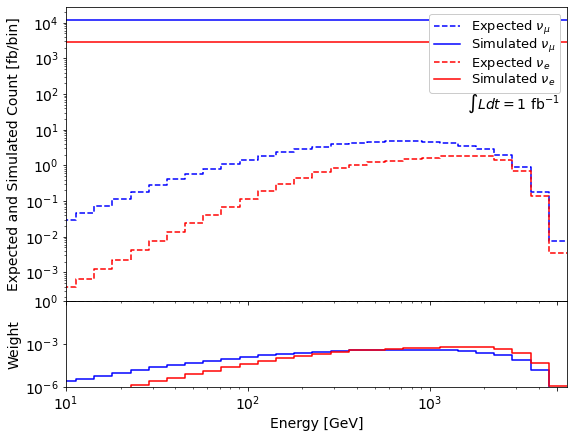

In [18]:
lum = 1
weights_numu = (expTot_numu*lum)/simTot_numu
weights_nuel = (expTot_nuel*lum)/simTot_nuel

# Configure datasets for plot1D()
weights_numu_dataset=np.array([expEnergy_numu, weights_numu, np.zeros(np.shape(weights_numu))])
expTot_numu_dataset=np.array([expEnergy_numu, expTot_numu*lum, np.zeros(np.shape(expTot_numu))])
simTot_numu_dataset=np.array([[0,np.max(expEnergy_numu)], [simTot_numu,simTot_numu], [0, 0]])

weights_nuel_dataset=np.array([expEnergy_nuel, weights_nuel, np.zeros(np.shape(weights_nuel))])
expTot_nuel_dataset=np.array([expEnergy_nuel, expTot_nuel*lum, np.zeros(np.shape(expTot_nuel))])
simTot_nuel_dataset=np.array([[0,np.max(expEnergy_nuel)], [simTot_numu,simTot_nuel], [0, 0]])

fig = plt.figure(figsize=(8,6))
# Setup some nice axes
x0, x1 = 0.11, 0.98
y0, y1 = 0.1, 0.88 # 0.20 = 0.05 + 0.9/6
h = 0.2

ax0 = fig.add_axes([x0 , y0    , (x1-x0), h])
ax1 = fig.add_axes([x0 , y0 + h, (x1-x0), y1-h])

# Plot the weights
plt.sca(ax0)
plot1D(weights_numu_dataset, color='b')
plot1D(weights_nuel_dataset, color='r')
plot1D(np.array([[0,np.max(expEnergy_numu)],[1,1], [0, 0]]), linestyle='--', color='k')

plt.xlim([np.min(expEnergy_numu),np.max(expEnergy_numu)])
plt.ylim([10**-6,1])
plt.xscale('log')
plt.yscale('log')
plt.xticks([10, 100, 1000, 5000])
plt.yticks([10**-6,10**-3,1])

plt.xlabel('Energy [GeV]')
plt.ylabel('Weight')


# Plot the counts
plt.sca(ax1)
plot1D(expTot_numu_dataset, color='b', linestyle='--', label='Expected $\\nu_\mu$')
plot1D(simTot_numu_dataset, color='b', label='Simulated $\\nu_\mu$')
plot1D(expTot_nuel_dataset, color='r', linestyle='--', label='Expected $\\nu_e$')
plot1D(simTot_nuel_dataset, color='r', label='Simulated $\\nu_e$')

plt.xlim([np.min(expEnergy_numu),np.max(expEnergy_numu)])
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13, loc = "upper right")
plt.text(1.6*10**3,4*10**1,"$\int L dt = 1 ~\mathrm{fb}^{-1}$")
plt.xticks([10, 100, 1000, 5000])
ax1.set_xticklabels([])
plt.ylabel('Expected and Simulated Count [fb/bin]')

fig.savefig('GeneratedPlots/Fig_exp_sim_nu.pdf')

# Scintillators

In [19]:
data_muon_pass_0 = np.load('PlotsDataArrays/data_muon_pass_0.npy')
data_muon_pass_0111 = np.load('PlotsDataArrays/data_muon_pass_0111.npy')
data_muon_pass_01111 = np.load('PlotsDataArrays/data_muon_pass_01111.npy')

data_numu_pass_0 = np.load('PlotsDataArrays/data_numu_pass_0.npy')
data_numu_pass_01111 = np.load('PlotsDataArrays/data_numu_pass_01111.npy')

data_nuel_pass_0 = np.load('PlotsDataArrays/data_nuel_pass_0.npy')
data_nuel_pass_01111 = np.load('PlotsDataArrays/data_nuel_pass_01111.npy')

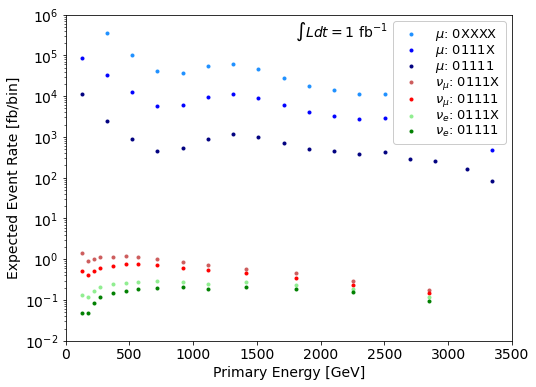

In [20]:
# prepare plot
fig = plt.figure(figsize=(8,6))

# one axis for all lines
ax = plt.subplot(1,1,1)

plt.sca(ax)
plot1D(data_muon_pass_0,     style='scatter', color="dodgerblue", label='$\mu$: 0XXXX')
plot1D(data_muon_pass_0111,  style='scatter', color="blue",       label='$\mu$: 0111X')
plot1D(data_muon_pass_01111, style='scatter', color="navy",       label='$\mu$: 01111')

plot1D(data_numu_pass_0,     style='scatter', color="indianred",  label='$\\nu_\mu$: 0111X')
plot1D(data_numu_pass_01111, style='scatter', color="red",        label='$\\nu_\mu$: 01111')

plot1D(data_nuel_pass_0,     style='scatter', color="lightgreen", label='$\\nu_e$: 0111X')
plot1D(data_nuel_pass_01111, style='scatter', color="green",      label='$\\nu_e$: 01111')

plt.yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13, loc='upper right');
plt.text(1800,3*10**5,"$\int L dt = 1 ~\mathrm{fb}^{-1}$")

plt.xlabel('Primary Energy [GeV]');
plt.ylabel('Expected Event Rate [fb/bin]');

plt.xlim([0, 3500]);
plt.ylim([10**-2, 10**6]);

fig.savefig('GeneratedPlots/Fig_scint_cuts.pdf')

# Calorimeter

In [21]:
data_numu = np.load('PlotsDataArrays/data_ecalo_numu.npy')
data_nuel = np.load('PlotsDataArrays/data_ecalo_nuel.npy')
data_muon = np.load('PlotsDataArrays/data_ecalo_muon.npy')

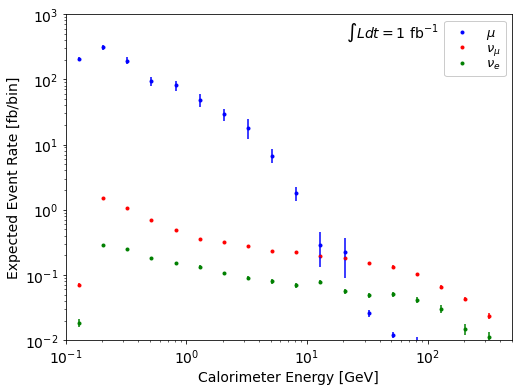

In [22]:
# prepare plot
fig = plt.figure(figsize=(8,6))

# one axis for all lines
ax = plt.subplot(1,1,1)

plt.sca(ax)

plot1D(data_muon, style='scatter', color="blue",  label='$\mu$')
plot1D(data_numu, style='scatter', color="red",   label='$\\nu_\mu$')
plot1D(data_nuel, style='scatter', color="green", label='$\\nu_e$')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13, loc='upper right');
plt.text(2.1*10**1,450,"$\int L dt = 1 ~\mathrm{fb}^{-1}$")

plt.xlabel('Calorimeter Energy [GeV]');
plt.ylabel('Expected Event Rate [fb/bin]');

plt.xlim([10**-1, 500]);
plt.ylim([10**-2, 10**3]);

fig.savefig('GeneratedPlots/Fig_ecalo.pdf')

# N tracks

In [23]:
data_numu = np.load('PlotsDataArrays/data_ntracks1_numu.npy')
data_nuel = np.load('PlotsDataArrays/data_ntracks1_nuel.npy')
data_muon = np.load('PlotsDataArrays/data_ntracks1_muon.npy')

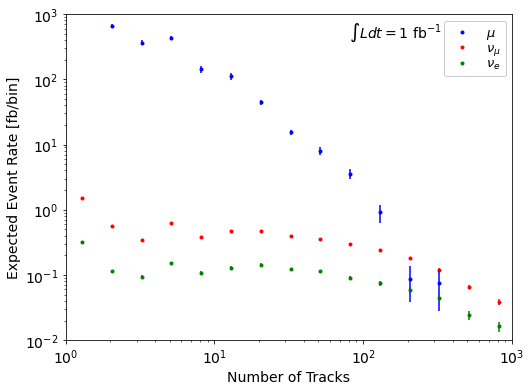

In [24]:
# prepare plot
fig = plt.figure(figsize=(8,6))

# one axis for all lines
ax = plt.subplot(1,1,1)

plt.sca(ax)

plot1D(data_muon, style='scatter', color="blue",  label='$\mu$')
plot1D(data_numu, style='scatter', color="red",   label='$\\nu_\mu$')
plot1D(data_nuel, style='scatter', color="green", label='$\\nu_e$')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13, loc='upper right');
plt.text(8*10**1,450,"$\int L dt = 1 ~\mathrm{fb}^{-1}$")

plt.xlabel('Number of Tracks');
plt.ylabel('Expected Event Rate [fb/bin]');

plt.xlim([10**0, 10**3]);
plt.ylim([10**-2, 10**3]);

fig.savefig('GeneratedPlots/Fig_ntracks.pdf')

# Tracker Observables + Calorimeter

In [25]:
bins1 = np.load('PlotsDataArrays/ntracks_ecalo_cal_bins1.npy')
bins2 = np.load('PlotsDataArrays/ntracks_ecalo_ntr_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/ntracks_ecalo_nu.npy')
selected_data_b = np.load('PlotsDataArrays/ntracks_ecalo_mu.npy')

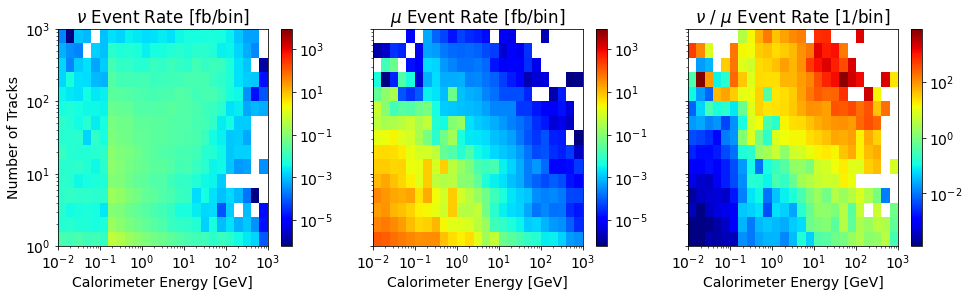

In [26]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Number of Tracks')
plt.title('$\\nu$ Event Rate [fb/bin]')
hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')
hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')


for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Calorimeter Energy [GeV]')
    ax.set_xscale('log');
    ax.set_yscale('log');
    
fig.savefig('GeneratedPlots/Fig_ntracks_ecalo.pdf')

In [27]:
bins1 = np.load('PlotsDataArrays/central_ecalo_cal_bins1.npy')
bins2 = np.load('PlotsDataArrays/central_ecalo_cen_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/central_ecalo_nu.npy')
selected_data_b = np.load('PlotsDataArrays/central_ecalo_mu.npy')

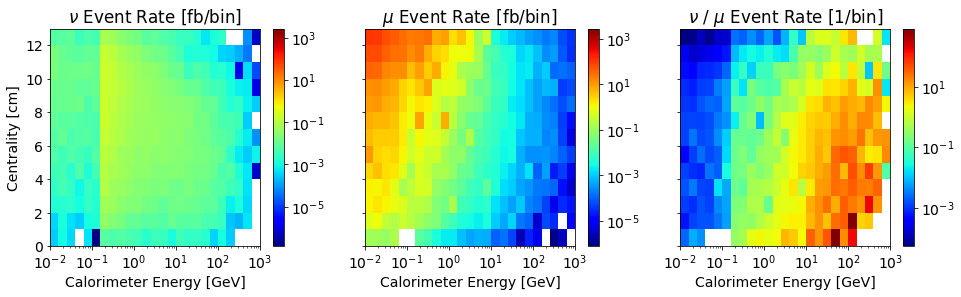

In [28]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Centrality [cm]')
plt.title('$\\nu$ Event Rate [fb/bin]')

hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')

hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Calorimeter Energy [GeV]')
    ax.set_xscale('log');
#     ax.set_yscale('log');

fig.savefig('GeneratedPlots/Fig_central_ecalo.pdf')

In [29]:
bins1 = np.load('PlotsDataArrays/spread_ecalo_cal_bins1.npy')
bins2 = np.load('PlotsDataArrays/spread_ecalo_spr_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/spread_ecalo_nu.npy')
selected_data_b = np.load('PlotsDataArrays/spread_ecalo_mu.npy')

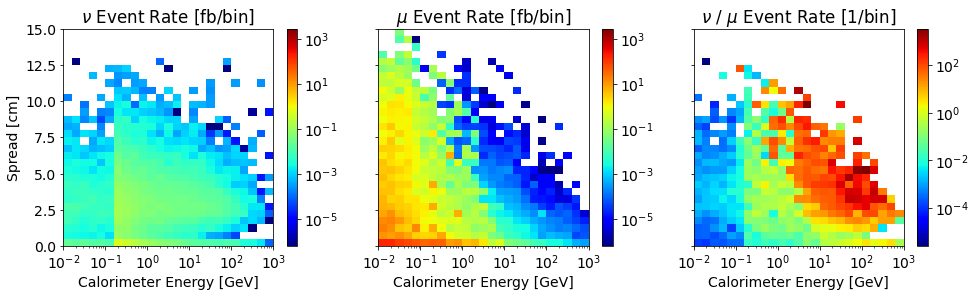

In [30]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Spread [cm]')
plt.title('$\\nu$ Event Rate [fb/bin]')

hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')

hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Calorimeter Energy [GeV]')
    ax.set_xscale('log');
#     ax.set_yscale('log');

fig.savefig('GeneratedPlots/Fig_spread_ecalo.pdf')

# Tracker Observable + Tracker Observable

In [31]:
bins1 = np.load('PlotsDataArrays/ntracks_centrality_ntr_bins1.npy')
bins2 = np.load('PlotsDataArrays/ntracks_centrality_cen_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/ntracks_centrality_nu.npy')
selected_data_b = np.load('PlotsDataArrays/ntracks_centrality_mu.npy')

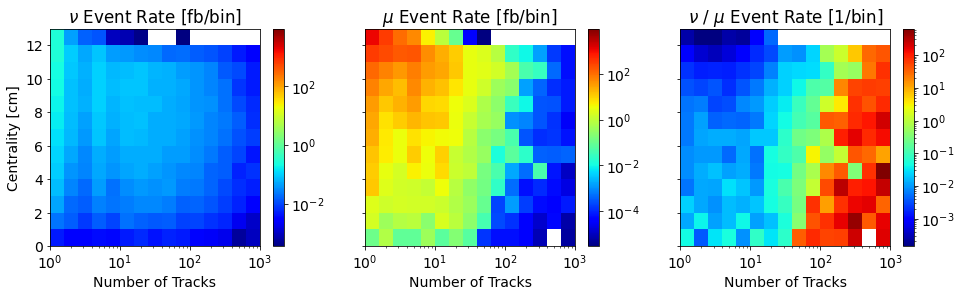

In [32]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Centrality [cm]')
plt.title('$\\nu$ Event Rate [fb/bin]')

hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')

hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Number of Tracks')
    ax.set_xscale('log');
#     ax.set_yscale('log');

fig.savefig('GeneratedPlots/Fig_central_ntracks.pdf')

In [33]:
bins1 = np.load('PlotsDataArrays/ntracks_spread_ntr_bins1.npy')
bins2 = np.load('PlotsDataArrays/ntracks_spread_spr_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/ntracks_spread_nu.npy')
selected_data_b = np.load('PlotsDataArrays/ntracks_spread_mu.npy')

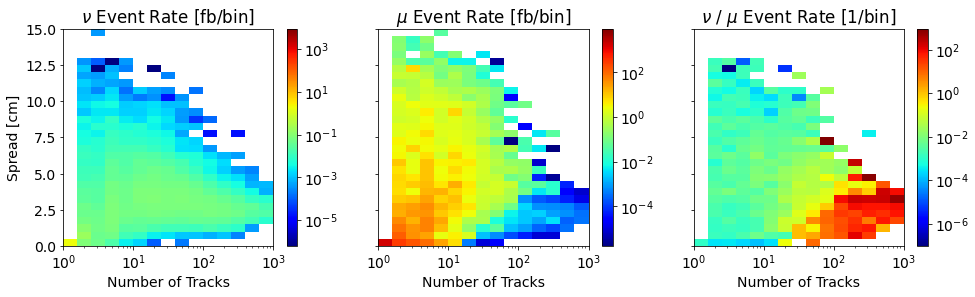

In [34]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Spread [cm]')
plt.title('$\\nu$ Event Rate [fb/bin]')

hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')

hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Number of Tracks')
    ax.set_xscale('log');
#     ax.set_yscale('log');

fig.savefig('GeneratedPlots/Fig_spread_ntracks.pdf')

In [35]:
bins1 = np.load('PlotsDataArrays/centrality_spread_cen_bins1.npy')
bins2 = np.load('PlotsDataArrays/centrality_spread_spr_bins2.npy')
selected_data_s = np.load('PlotsDataArrays/centrality_spread_nu.npy')
selected_data_b = np.load('PlotsDataArrays/centrality_spread_mu.npy')

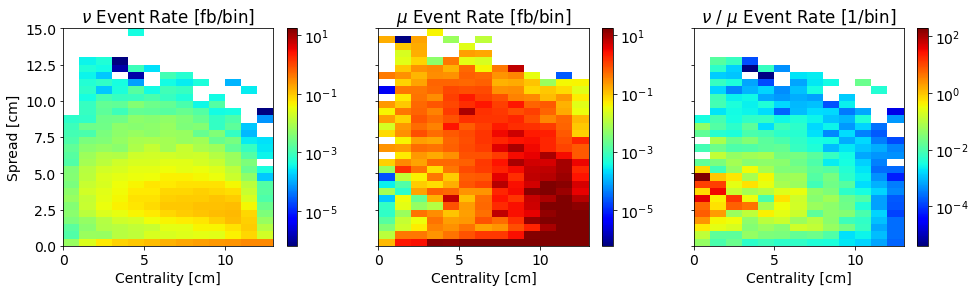

In [36]:
# prepare axes
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,4))


vmax = np.max(selected_data_b)
hs = plot2D(selected_data_s, bins1, bins2, ax = ax1, vmax = vmax);
plt.sca(ax1)
plt.colorbar(hs[3])
plt.ylabel('Spread [cm]')
plt.title('$\\nu$ Event Rate [fb/bin]')

hb = plot2D(selected_data_b, bins1, bins2, ax = ax2, vmax = vmax);
plt.sca(ax2)
plt.colorbar(hb[3])
plt.title('$\mu$ Event Rate [fb/bin]')

hr = plot2Dratio(hs, hb, bins1, bins2, ax = ax3, vmax = vmax)
plt.sca(ax3)
plt.colorbar(hr[3])
plt.title('$\\nu~/~\mu$ Event Rate [1/bin]')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Centrality [cm]')
#     ax.set_xscale('log');
#     ax.set_yscale('log');

fig.savefig('GeneratedPlots/Fig_spread_central.pdf')

# Cut-Flow Analysis

Define functions for calculating the pvalues and significance of various cuts

In [37]:
def mylogpmf(k,mu):
    return special.xlogy(k, mu) - gamln(k + 1) - mu
    
# claculated -2*log_r 
def m2logr(ns, nb, mu=1):
    log_pois_sb = mylogpmf(k=ns+nb, mu=mu*ns+nb)
    log_pois_b  = mylogpmf(k=ns+nb, mu=ns+nb   )
    log_r_rate  = log_pois_sb - log_pois_b
    return -2*log_r_rate

def calc_sig(Ns, Nb):
    return np.sqrt(m2logr(Ns, Nb, 0))

Import data for various cuts

In [38]:
# Data is formatted as [Ecal, Nmin, Smax, Ns, ds, Nb, db]
cut_analysis = np.load('PlotsDataArrays/cut_analysis.npy')

There are initally 150 total cuts. Let's reduce it by requiring a certain minimum significance, say at least 3 sigma significance at 10 ifb. We scale up the background by adding 10 times our estimated systematic uncertainty to ensure that these cuts have smaller backgrounds.

In [39]:
# Calculate significances 
lum=15

sigs = []
for data in cut_analysis:
    sigs.append(calc_sig(data[3]*lum,(data[5])*lum))
#     sigs.append(calc_sig(data[3]*lum,(data[5]+100*data[6])*lum))
sigs = np.array(sigs)

In [40]:
min_sig = 5
cut_analysis_red_1 = cut_analysis[sigs >= min_sig]
sigs_red_1 = sigs[sigs >= min_sig]

In [41]:
np.shape(cut_analysis_red_1)

(66, 7)

Let's further reduce the cuts by requiring a certain number of events

Let's say 10 neutrino events at 20 ifb

In [42]:
min_Ns = 10 / 20
cut_analysis_red_2 = cut_analysis_red_1[cut_analysis_red_1[:,3] >= min_Ns]
sigs_red_2 = sigs_red_1[cut_analysis_red_1[:,3] >= min_Ns]

In [43]:
np.shape(cut_analysis_red_2)

(24, 7)

There are still 33 total cuts. Let's see what some of them are.

In [44]:
lum = 10

print('Emin    Nmin    Smax    Ns      Nb      db      sig')
print('---------------------------------------------------')
for (cut, sig) in zip(cut_analysis_red_2,sigs_red_2):
    Emin, Nmin, Smax = cut[:3]
    Ns = cut[3]*lum
    Nb = cut[5]*lum
    db = cut[6]*lum
    print(' '   + str(Emin),           ' \t' + str(Nmin),            ' \t' + str(Smax),
          ' \t' + str(np.round(Ns,2)), ' \t' + str(np.round(Nb,2)),
          ' \t' + str(np.round(db,3)), ' \t' + str(np.round(sig,2)))

Emin    Nmin    Smax    Ns      Nb      db      sig
---------------------------------------------------
 0.0  	100.0  	3.0  	6.44  	0.23  	0.028  	6.92
 0.0  	100.0  	4.0  	8.59  	1.44  	0.551  	5.71
 0.0  	150.0  	4.0  	6.17  	0.55  	0.254  	5.65
 1.0  	10.0  	20.0  	15.09  	5.23  	1.792  	6.12
 1.0  	10.0  	4.0  	11.26  	2.51  	0.707  	6.04
 1.0  	10.0  	6.0  	14.51  	3.22  	0.847  	6.87
 1.0  	50.0  	20.0  	8.69  	0.4  	0.27  	7.69
 1.0  	50.0  	3.0  	5.06  	0.11  	0.006  	6.67
 1.0  	50.0  	4.0  	7.5  	0.39  	0.27  	6.96
 1.0  	50.0  	6.0  	8.58  	0.4  	0.27  	7.63
 1.0  	100.0  	20.0  	5.72  	0.06  	0.005  	7.9
 1.0  	100.0  	4.0  	5.33  	0.06  	0.005  	7.59
 1.0  	100.0  	6.0  	5.71  	0.06  	0.005  	7.89
 5.0  	10.0  	20.0  	8.6  	0.36  	0.129  	7.79
 5.0  	10.0  	4.0  	6.72  	0.34  	0.129  	6.63
 5.0  	10.0  	6.0  	8.34  	0.35  	0.129  	7.65
 5.0  	50.0  	20.0  	5.71  	0.03  	0.002  	8.56
 5.0  	50.0  	4.0  	5.01  	0.03  	0.002  	7.95
 5.0  	50.0  	6.0  	5.66  	0.03  	0.002  	8.

In [45]:
# Define functions to create mask and find the index of a cut
create_mask = lambda Emin, Nmin, Smax : np.logical_and(np.logical_and(cut_analysis[:,0] == Emin, cut_analysis[:,1] == Nmin), cut_analysis[:,2] == Smax)
find_ind = lambda Emin, Nmin, Smax : np.where(create_mask(Emin, Nmin, Smax))[0][0]

# Function for generating tick labels for plot
def generate_label(Emin, Nmin, Smax):
    p1 = f"$E_\mathrm{'{min}'} = {str(int(Emin))}$\n"
    if Emin == 0: p1 = ""
    p2 = f"$N_\mathrm{'{min}'} = {str(int(Nmin))}$\n"
    if Nmin == 0: p2 = ""
    p3 = f"$S_\mathrm{'{max}'} = {str(int(Smax))}$"
    if Smax == 20: p3 = ""
    return p1 + p2 + p3

In [46]:
# Define interesting cuts
# cuts = [#Emin, Nmin, Smax
#         [1,      0,   20],
#         [5,      0,   20],
#         [10,     0,   20],
#         [0,     10,   20],
#         [0,     50,   20],
#         [0,    100,   20],
#         [1,    100,   20],
#         [0,    100,    3],
#         [5,     50,    6],
#        ]

cuts = [#Emin, Nmin, Smax
        [1,      0,   20],
        [15,     0,   20],
        [0,     50,   20],
        [0,    100,   20],
        [0,    100,    6],
        [0,    100,    3],
        [1,    100,   20],
        [5,     50,    6],
       ]

inds = [find_ind(Emin,Nmin,Smax) for [Emin, Nmin, Smax] in cuts]
analyses = cut_analysis[inds]

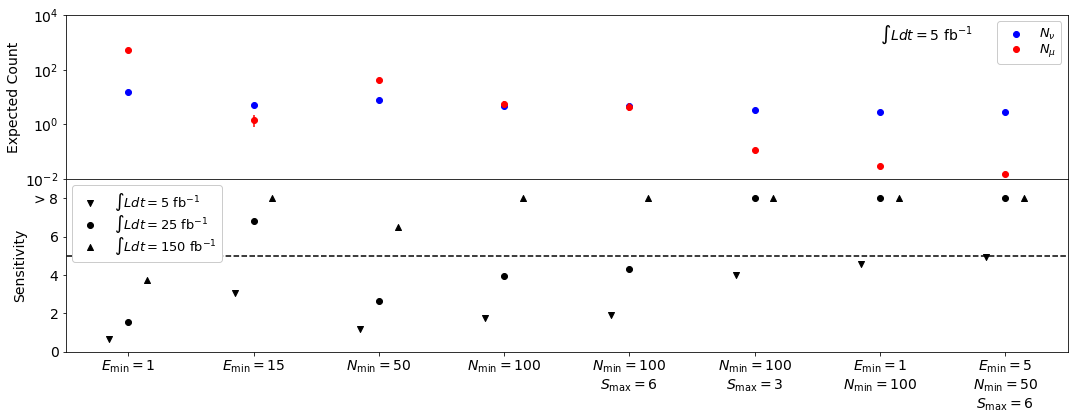

In [148]:
fig = plt.figure(figsize=(16,6))
# Setup some nice axes
x0, x1 = 0.11, 0.98
y0, y1 = 0.2, 0.78
h = 0.4

ax1 = fig.add_axes([x0 , y0 + h, (x1-x0), y1-h])
ax0 = fig.add_axes([x0 , y0    , (x1-x0), h])

lums = [5, 25, 150]
markers = ['v','o', '^']

lum_datasets = []
for lum in lums:
    i=0
    Ns_dataset=[]
    Nb_dataset=[]
    sig_dataset=[]
    xticklabels=[]
    for analysis in analyses:
        i+=1
        Emin, Nmin, Smax, Ns, ds, Nb, db = analysis

        plt.sca(ax1)
        Ns_dataset.append([i,Ns*lum,ds*lum])
        Nb_dataset.append([i,Nb*lum,db*lum])
        sig_dataset.append([i,calc_sig(Ns*lum,(Nb)*lum),0])
        xticklabels.append(generate_label(Emin, Nmin, Smax))
    lum_datasets.append([np.array(Ns_dataset), np.array(Nb_dataset), np.array(sig_dataset)])

offsets = [-0.15, 0, 0.15]
for marker, lum, (Ns_dataset, Nb_dataset, sig_dataset), offset in zip(markers, lums, lum_datasets, offsets):
    plt.sca(ax1)
    if lum == lums[0]:
        plot1D(Ns_dataset.T, style='scatter', color='b', marker='o',
              label="$N_\\nu$")
        plot1D(Nb_dataset.T, style='scatter', color='r', marker='o',
              label="$N_\mu$")
    
    plt.sca(ax0)
    sig_dataset[:,0] += offset
    mask = sig_dataset[:,1] > 8
    sig_dataset[mask,1] = 8
    plot1D(sig_dataset.T, style='scatter', marker=marker,
          label=f"$\int Ldt={lum}~\mathrm{'{fb^{-1}}'}$")

plt.sca(ax1)
# plt.grid()
plt.xlim([0.5,len(cuts)+0.5]);
ax1.set_xticklabels([])
plt.ylim([10**-2,10**4]);
plt.yscale('log')
plt.ylabel('Expected Count');
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13,loc="upper right")
# plt.text(0.55,2.6,"$\int L dt = 5 ~\mathrm{fb}^{-1}$")
plt.text(len(cuts)-1,1200,"$\int L dt = 5 ~\mathrm{fb}^{-1}$")

plt.sca(ax0)
plt.plot([0,10],[5,5], '--k')
# plt.grid()
plt.xticks([n+1 for n in range(len(analyses))],xticklabels, rotation=0)
plt.xlim([0.5,len(cuts)+0.5]);
plt.ylim([0,9]);
plt.yticks([0, 2, 4, 6, 8], ['0', '2', '4', '6', '$> 8$'])
plt.ylabel('Sensitivity');
# plt.yscale('log')
plt.legend(frameon=True, framealpha=1, labelspacing=0, fontsize=13,loc="upper left");

fig.savefig('GeneratedPlots/Fig_cut_analysis.pdf')

### Cross Section Measurement

In [48]:
neutrino_events = np.load('PlotsDataArrays/neutrino_events_full.npy', allow_pickle=True)

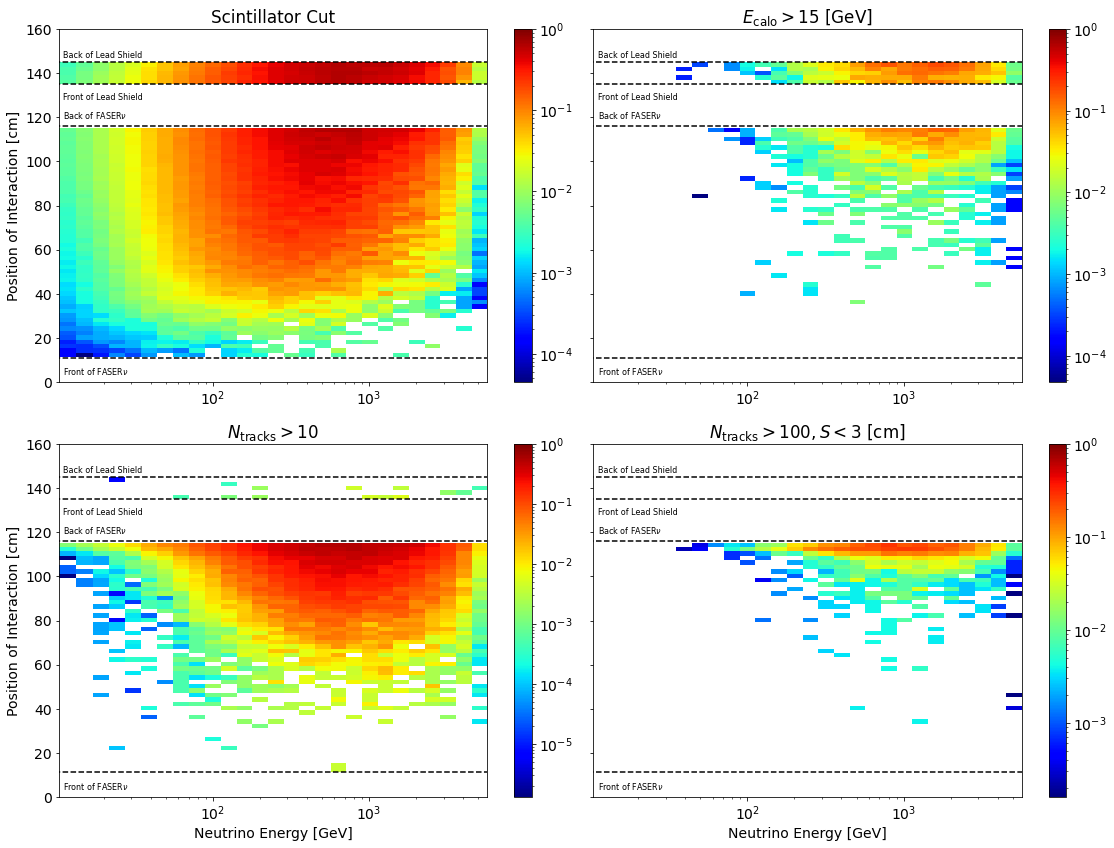

In [53]:
lum = 10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(16,12))
zpostions = np.concatenate((np.arange(11.3,116.2,2), np.arange(135,147,2)))

fig.sca(ax1)

primary_data = [[event['primaryEnergy'], event['zposition'], event['weight']*lum] for event in neutrino_events]
primary_data = np.array(primary_data)
hs = plot2D(primary_data, expEnergy_numu-1, zpostions, vmax=1, ax=ax1)
plt.colorbar(hs[3], ax=ax1)
plt.xscale('log')
plt.plot([10**-1,10**4],[11.2, 11.2], 'k--')
t = plt.text(1.1*10**1,3.2, 'Front of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[116.2, 116.2], 'k--')
t = plt.text(1.1*10**1,119.2, 'Back of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[135, 135], 'k--')
t = plt.text(1.1*10**1,128, 'Front of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[145, 145], 'k--')
t = plt.text(1.1*10**1,147, 'Back of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.tight_layout();

plt.ylabel('Position of Interaction [cm]');
plt.title('Scintillator Cut')

fig.sca(ax2)

cut_events = [event for event in neutrino_events if
                 event['calorimeter'] > 15]
primary_data = [[event['primaryEnergy'], event['zposition'], event['weight']*lum] for event in cut_events]
primary_data = np.array(primary_data)
hs = plot2D(primary_data, expEnergy_numu-1, zpostions, vmax=1, ax=ax2)
plt.colorbar(hs[3], ax=ax2)
plt.xscale('log')
plt.plot([10**-1,10**4],[11.2, 11.2], 'k--')
t = plt.text(1.1*10**1,3.2, 'Front of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[116.2, 116.2], 'k--')
t = plt.text(1.1*10**1,119.2, 'Back of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[135, 135], 'k--')
t = plt.text(1.1*10**1,128, 'Front of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[145, 145], 'k--')
t = plt.text(1.1*10**1,147, 'Back of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.tight_layout();

plt.title('$E_\mathrm{calo} > 15~\mathrm{[GeV]}$')

fig.sca(ax3)

cut_events = [event for event in neutrino_events if
                 event['ntracks_1'] > 10]
primary_data = [[event['primaryEnergy'], event['zposition'], event['weight']*lum] for event in cut_events]
primary_data = np.array(primary_data)
hs = plot2D(primary_data, expEnergy_numu-1, zpostions, vmax=1, ax=ax3)
plt.colorbar(hs[3], ax=ax3)
plt.xscale('log')
plt.plot([10**-1,10**4],[11.2, 11.2], 'k--')
t = plt.text(1.1*10**1,3.2, 'Front of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[116.2, 116.2], 'k--')
t = plt.text(1.1*10**1,119.2, 'Back of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[135, 135], 'k--')
t = plt.text(1.1*10**1,128, 'Front of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[145, 145], 'k--')
t = plt.text(1.1*10**1,147, 'Back of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.tight_layout();

plt.xlabel('Neutrino Energy [GeV]');
plt.ylabel('Position of Interaction [cm]');
plt.title('$N_\mathrm{tracks} > 10$')

fig.sca(ax4)

cut_events = [event for event in neutrino_events if
                 event['ntracks_1'] > 100 and event['spread_1'] < 3]
primary_data = [[event['primaryEnergy'], event['zposition'], event['weight']*lum] for event in cut_events]
primary_data = np.array(primary_data)
hs = plot2D(primary_data, expEnergy_numu-1, zpostions, vmax=1, ax=ax4)
plt.colorbar(hs[3], ax=ax4)
plt.xscale('log')
plt.plot([10**-1,10**4],[11.2, 11.2], 'k--')
t = plt.text(1.1*10**1,3.2, 'Front of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[116.2, 116.2], 'k--')
t = plt.text(1.1*10**1,119.2, 'Back of FASER$\\nu$', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[135, 135], 'k--')
t = plt.text(1.1*10**1,128, 'Front of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.plot([10**-1,10**4],[145, 145], 'k--')
t = plt.text(1.1*10**1,147, 'Back of Lead Shield', fontsize=8)
# t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.tight_layout();
plt.title('$N_\mathrm{tracks} > 100, S < 3~\mathrm{[cm]}$')

plt.xlabel('Neutrino Energy [GeV]');
plt.ylim([0,160]);

fig.savefig('GeneratedPlots/Fig_cut_effect.pdf')

In [75]:
zpostions = np.concatenate((np.arange(11.2,116.2,2), np.arange(135,147,2)))

cut_events = [event for event in neutrino_events if
                 event['ntracks_1'] > 100 and event['spread_1'] < 3]

In [118]:
event_array = {}
for zpos in np.concatenate((np.arange(11.2,116.2,2), np.arange(135,147,2))):
    select_events = [event for event in cut_events if event['zposition'] == zpos]
    tmp={}
    for event in select_events:
        if event['primaryEnergy'] in tmp.keys():
            tmp[event['primaryEnergy']] += event['weight']
        else:
            tmp[event['primaryEnergy']] = event['weight']
    event_array[zpos] = tmp

In [116]:
data = []
energies = sorted(event_array.keys())
for energy in energies:
    data.append(event_array[energy])

In [117]:
sum(data)

0.19652830188679182

In [119]:
event_array

{11.2: {},
 13.2: {},
 15.2: {},
 17.2: {},
 19.2: {},
 21.2: {},
 23.2: {},
 25.2: {},
 27.2: {},
 29.2: {},
 31.2: {},
 33.2: {},
 35.2: {1136.953: 0.0003908866864391718},
 37.2: {},
 39.2: {},
 41.2: {4526.3: 3.14716839543381e-05, 452.63: 0.0003696312607089609},
 43.2: {},
 45.2: {},
 47.2: {4526.3: 1.573584197716905e-05},
 49.2: {},
 51.2: {},
 53.2: {},
 55.2: {},
 57.2: {},
 59.2: {717.37075: 0.0004144148085157612, 1136.953: 0.0005636533994055377},
 61.2: {},
 63.2: {717.37075: 0.0004144148085157612},
 65.2: {359.5365: 0.0003332472321038454},
 67.2: {285.59015: 0.00029064285075166657},
 69.2: {},
 71.2: {1431.3429: 0.00036214952960699886, 569.8274: 0.000416819872735484},
 73.2: {1431.3429: 0.00036214952960699886,
  5698.274: 6.459756194821698e-07,
  226.85205: 0.0002464281452291831},
 75.2: {717.37075: 0.0004144148085157612, 569.8274: 0.00039767571075502347},
 77.2: {717.37075: 0.0004144148085157612, 1431.3429: 0.00036214952960699886},
 79.2: {717.37075: 0.0004144148085157612},
 

array([0.03052942, 0.04688155, 0.07482855, 0.11695608, 0.18402551,
       0.28167155, 0.41695819, 0.59694487, 0.84117023, 1.15747993,
       1.54911472, 2.03378473, 2.62337125, 3.29473986, 3.98824957,
       4.68067751, 5.29496823, 5.79217111, 6.13592304, 6.17845136,
       6.1374684 , 5.95647611, 5.44007269, 4.62152912, 3.32837414,
       1.60773413, 0.31691482, 0.01097977])

In [143]:
numu_FluData = np.loadtxt('../FastNeutrinoFluxSimulation/Fluxes/FASERv/FASER_14.txt')
numu_bar_FluData = np.loadtxt('../FastNeutrinoFluxSimulation/Fluxes/FASERv/FASER_-14.txt')

nuel_FluData = np.loadtxt('../FastNeutrinoFluxSimulation/Fluxes/FASERv/FASER_12.txt')
nuel_bar_FluData = np.loadtxt('../FastNeutrinoFluxSimulation/Fluxes/FASERv/FASER_-12.txt')

lum = 10

nu_FluData = [numu_FluData[:,0], (numu_FluData[:,1] + numu_bar_FluData[:,1] + nuel_FluData[:,1] + nuel_bar_FluData[:,1])*lum/150]
nu_FluData = np.array(nu_FluData).T

In [144]:
N_int_E = []
eps = 1
for energy in nu_FluData[:,0]:
    selected_events = [event for event in cut_events if (event['primaryEnergy'] > energy - eps and event['primaryEnergy'] < energy + eps)]
    tot_weight = np.sum([event['weight'] for event in selected_events])
    N_int_E.append(tot_weight * lum)
N_int_E = np.array(N_int_E)

In [146]:
np.sum(N_int_E)

7.785034886095571

In [164]:
mp = 938.272081 * 1.78266269594644 * 10 ** -30 # MeV to kg
rho = 19.3 * 10 ** -3 # Density of tungsten # kg / cm^3
L = 2 # cm

xsec_E_mean = (mp / (rho * L) ) * N_int_E / nu_FluData[:,1]
xsec_E_err = (mp / (rho * L) ) * np.sqrt(N_int_E) / nu_FluData[:,1]

In [ ]:
P_E = (N_int_E)

In [168]:
xsec_E_mean

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.05393269e-39, 2.87988681e-39, 5.42741336e-39,
       3.07617282e-38, 4.75454898e-38, 1.17257662e-37, 1.86809680e-37,
       3.58533988e-37, 6.48736888e-37, 1.03261244e-36, 1.42485345e-36,
       2.15990951e-36, 2.76653225e-36, 3.98295538e-36, 4.64005833e-36,
       6.32886893e-36, 6.99566450e-36, 9.18568060e-36, 9.60283035e-36,
       1.18531274e-35, 1.49007068e-35, 1.47906730e-35, 1.41302169e-35])

In [170]:
(mp / (rho * L) ) * (expTot_numu_dataset[1] + expTot_nuel_dataset[1]) / nu_FluData[:,1]

array([3.13123154e-37, 4.10629345e-37, 5.53374353e-37, 7.32911618e-37,
       9.68174115e-37, 1.25025561e-36, 1.60913838e-36, 2.06085374e-36,
       2.62542036e-36, 3.33138882e-36, 4.23447210e-36, 5.36747273e-36,
       6.79927602e-36, 8.60901816e-36, 1.08046743e-35, 1.36838917e-35,
       1.73174681e-35, 2.19714158e-35, 2.78684508e-35, 3.52306583e-35,
       4.47143772e-35, 5.70118842e-35, 7.20446303e-35, 9.18836512e-35,
       1.16742636e-34, 1.45381715e-34, 1.72677195e-34, 1.94652012e-34])